In [1]:
import os
import pandas as pd
import numpy as np
import time
import re
import seaborn as sns

In [2]:
def load_data_from_folder(folder_path, skiprows=0, cols_to_read=None):
    ''' Load data from a folder, combine all files data vertically. (files should have same columns)'''
    # Get a list of all files in the folder
    all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Initialize an empty DataFrame to store the combined data
    df_combine = pd.DataFrame()

    # Loop through the files, read the data, and append it to the combined_data DataFrame
    for file in all_files:
        file_path = os.path.join(folder_path, file)

        # Read the data from the current file
        print("Loading " + file)
        df_curr = pd.read_excel(file_path, skiprows=skiprows, usecols=cols_to_read)
        

        # Append data to combined_data DataFrame
        df_combine = pd.concat([df_combine, df_curr], axis=0, ignore_index=True)
    return df_combine

In [3]:
def load_csv_data_from_folder(folder_path, skiprows=0, cols_to_read=None, dtype=None):
    ''' Load csv data files from a folder, combine all data vertically. (files should have same columns)'''
    # Get a list of all files in the folder
    all_files = [f for f in os.listdir(folder_path) if os.path.isfile(os.path.join(folder_path, f))]

    # Initialize an empty DataFrame to store the combined data
    df_combine = pd.DataFrame()

    # Loop through the files, read the data, and append it to the combined_data DataFrame
    for file in all_files:
        file_path = os.path.join(folder_path, file)

        # Read the data from the current file
        print("Loading " + file)
        df_curr = pd.read_csv(file_path, skiprows=skiprows, usecols=cols_to_read, dtype=dtype, encoding='ISO-8859-1')
        

        # Append data to combined_data DataFrame
        df_combine = pd.concat([df_combine, df_curr], axis=0, ignore_index=True)
    return df_combine

In [24]:
def clean_channel(df, channel_str, coo_str, domestic_str):
    ''' Clean channel to three buckets: domestic, domestic-import, import.'''
    df['Channel_Clean'] = np.where((df[coo_str] == domestic_str) | (df[coo_str].isnull()), 
         'Domestic', 'Domestic-Import')
    df['Channel_Clean'] = np.where(df[channel_str] == 'Import', 'Import', df['Channel_Clean'])

def clean_data(df):
    # remove first column
    df.drop(df.columns[0], axis=1, inplace=True)
    
    # remove duplicates
    df.drop_duplicates(inplace=True)
    
    # clean channel
    clean_channel(df, 'CHANNEL_CODE', 'COUNTRY_CODE', 'United States')
    
    # reshape the dataframe
    id_vars = ['SBU_DESC', 'ACCTG_DEPT_DESC', 'DEPT_CATEGORY_DESC', 'CHANNEL_CODE',
       'COUNTRY_CODE', 'BRAND_INDICATOR', 'Channel_Clean']
    value_vars = [i for i in df.columns if ' - ' in i] # catch format pattern like "2023 - NOV"
    df = df.melt(id_vars=id_vars + ['DATA_TYPE'], value_vars=value_vars, var_name='Year_Month')
    df = pd.pivot_table(df, 
                        index=id_vars + ['Year_Month'], 
                        columns='DATA_TYPE', 
                        values='value').reset_index()
    
    # generate new columns
    df['Cost'] = df['TY_POS_QTY'] * df['AUC']
    df['year'] = df['Year_Month'].str.split("-", expand=True)[0].str.strip()
    df['month'] = df['Year_Month'].str.split("-", expand=True)[1].str.strip()
    
    return df

In [5]:
def clean_item_data(df):
    '''Clean item level data'''
    # remove first column
    df.drop(df.columns[0], axis=1, inplace=True)
    
    # remove duplicates
    df.drop_duplicates(inplace=True)
    
    # clean channel to three buckets: domestic, domestic-import, import
    df['Channel_Clean'] = np.where((df['COUNTRY_CODE'] == 'United States') | (df['COUNTRY_CODE'].isnull()), 
         'Domestic', 'Domestic-Import')
    df['Channel_Clean'] = np.where(df['CHANNEL_CODE'] == 'Import', 'Import', df['Channel_Clean'])
    
    return df

In [6]:
def convert_to_number(num_str):
    '''Convert string to number formatted string.'''
    if pd.isnull(num_str):
        return '0'
    
    num_str = num_str.replace("$", '').replace(",",'')
    
    if num_str[0] == '(': # negative numbers
        return '-' + num_str[1:-1]
    else:
        return num_str

In [7]:
def clean_container_data(df):
    ''' Clean combined data from container equivalency report'''
    
    convert_cols = ['Net Ship Units - Timeframe',
                     'Net Ships Cost - Timeframe',
                     'Net Ship Retail - Timeframe',
                     'Estimated 20ft Containers Per Month',
                     'Estimated 40ft Containers Per Month',
                     'Units Per 20ft Container',
                     'Units Per 40ft Container']
    # Conver string to number
    for col in convert_cols:
        df[col] = df[col].apply(convert_to_number).astype(float)
    
    # remove duplicates
    df.drop_duplicates(inplace=True)
    
    # Clean channel    
    clean_channel(df_container, 'Channel', 'Country of Origin', 'US')
    
    # Calculate new columns
    df['Estimated 20ft Containers'] = df['Estimated 20ft Containers Per Month'] * 12
    df['Estimated 40ft Containers'] = df['Estimated 40ft Containers Per Month'] * 12
    df['Calculated 20ft Containers'] = np.where(df['Units Per 20ft Container'] != 0, 
                                                df['Net Ship Units - Timeframe'] / df['Units Per 20ft Container'], 
                                                0)
    df['Calculated 40ft Containers'] = np.where(df['Units Per 40ft Container'] != 0, 
                                                df['Net Ship Units - Timeframe'] / df['Units Per 40ft Container'], 
                                                0)
    
    # Rename columns
    df.rename(columns={'Net Ship Units - Timeframe': 'Net Ship Units',
                     'Net Ships Cost - Timeframe': 'Net Ships Cost',
                     'Net Ship Retail - Timeframe': 'Net Ship Retail'}, inplace=True)

In [8]:
def check_agg(df, agg_list, values=['TY_POS_SALES', 'TY_POS_QTY', 'Cost', 'LY_POS_SALES', 'LY_POS_QTY']):
    return df.groupby(agg_list)[values].sum()

### Process category level data in excel files

In [16]:
folder_path = r'C:\Users\y0q00wv\Documents\Roger Qin\Data Analytics\BRI Import Analysis\Spine Reports - Mar 2024'

In [25]:
df = load_data_from_folder(folder_path, skiprows=10)
df = clean_data(df)

Loading apparel.xlsx
Loading consumables.xlsx
Loading entertainment.xlsx
Loading food.xlsx
Loading h&w.xlsx
Loading HL.xlsx
Loading home.xlsx
Loading others.xlsx
Loading toys_seasonal.xlsx


In [26]:
df.to_csv(folder_path + '//raw_data_cleaned.csv', index=False)

In [21]:
check_agg(df, ['Channel_Clean'])

DATA_TYPE,TY_POS_SALES,TY_POS_QTY,Cost,LY_POS_SALES,LY_POS_QTY
Channel_Clean,,,,,
Domestic,3.009624e+11,6.445451e+10,1.923325e+11,2.900497e+11,6.491309e+10
Domestic-Import,9.027466e+10,1.270758e+10,6.026010e+10,8.965238e+10,1.278609e+10
Import,3.203207e+10,4.389299e+09,2.008643e+10,3.352614e+10,4.470411e+09


In [124]:
check_agg(df, ['BRAND_INDICATOR', 'Channel_Clean']).to_clipboard()

### Process data from Container Equivalency reports

In [8]:
# Define the folder path
item_folder_path = r'C:\Users\y0q00wv\Documents\Roger Qin\Data Analytics\BRI Import Analysis\Spine Reports Item Level'
container_folder_path = r'C:\Users\y0q00wv\Documents\Roger Qin\Data Analytics\BRI Import Analysis\Spine Reports - Container Equivalency'

In [200]:
need_cols = ['SBU',
             'Item Number',
             'Item Description',
             'UPC Number',
             'Department Desc',
             'Dept Category Desc',
             'Channel',
             'Country of Origin',
             'Net Ship Units - Timeframe',
             'Net Ships Cost - Timeframe',
             'Net Ship Retail - Timeframe',
             'Estimated 20ft Containers Per Month',
             'Estimated 40ft Containers Per Month',
             'Units Per 20ft Container',
             'Units Per 40ft Container']
data_types = {'UPC Number':'int64',
              'Net Ship Units - Timeframe': str,
             'Net Ships Cost - Timeframe': str,
             'Net Ship Retail - Timeframe': str,
             'Estimated 20ft Containers Per Month': str,
             'Estimated 40ft Containers Per Month': str,
             'Units Per 20ft Container': str,
             'Units Per 40ft Container': str}

start_time = time.time()
df_container = load_csv_data_from_folder(container_folder_path, cols_to_read=need_cols, dtype=data_types)
end_time = time.time()

duration_time = round(end_time - start_time, 0)
print(f"File read in {duration_time // 60} minutes and {duration_time % 60} seconds")

# clean data
print("Cleaning data...")
clean_container_data(df_container)
print("Data clean complete")

Loading container_apparel_national_dep1.csv
Loading container_apparel_national_dep2.csv
Loading container_apparel_national_dep3.csv
Loading container_apparel_national_dep4.csv
Loading container_apparel_private_dome.csv
Loading container_apparel_private_impo.csv
Loading container_consumable.csv
Loading container_entertainment.csv
Loading container_food.csv
Loading container_HL.csv
Loading container_Home.csv
Loading container_HW.csv
Loading container_other.csv
Loading container_toys.csv
File read in 1.0 minutes and 57.0 seconds
Cleaning data...
Data clean complete


In [201]:
# filter to items with volume
df_container_volume = df_container[(df_container['Net Ship Units'] != 0) | (df_container['Net Ships Cost'] != 0) | (df_container['Net Ship Retail'] != 0)].copy()

Among all items with ship volume, 26.7% items don't have units per container information

In [214]:
df_container_volume[(df_container_volume['Units Per 20ft Container'] == 0) & \
                   (df_container_volume['Units Per 40ft Container'] == 0)].shape[0] / df_container_volume.shape[0]

0.26725128061595643

In [13]:
df_container.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 5498670 entries, 0 to 6191969
Data columns (total 18 columns):
 #   Column                               Dtype  
---  ------                               -----  
 0   SBU                                  object 
 1   Item Number                          int64  
 2   Department Desc                      object 
 3   Dept Category Desc                   object 
 4   Country of Origin                    object 
 5   Net Ship Units                       float64
 6   Net Ships Cost                       float64
 7   Net Ship Retail                      float64
 8   Channel                              object 
 9   Estimated 20ft Containers Per Month  float64
 10  Units Per 20ft Container             float64
 11  Estimated 40ft Containers Per Month  float64
 12  Units Per 40ft Container             float64
 13  Channel_Clean                        object 
 14  Estimated 20ft Containers            float64
 15  Estimated 40ft Containers       

In [202]:
# volume of items with no container info.
check_agg(df_container_volume[(df_container_volume['Units Per 20ft Container'] == 0) & \
                   (df_container_volume['Units Per 40ft Container'] == 0)],
          ['Channel_Clean'], 
          ['Net Ship Retail',
           'Net Ship Units',
             'Net Ships Cost']).to_clipboard()

In [203]:
df_container_volume.shape[0]

1586346

In [26]:
df_container_volume[['SBU', 'Item Number', 'Department Desc', 'Dept Category Desc',
       'Country of Origin', 'Net Ship Units', 'Net Ships Cost',
       'Net Ship Retail', 'Channel', 'Channel_Clean',
       'Estimated 20ft Containers', 'Estimated 40ft Containers']].head()

,SBU,Item Number,Department Desc,Dept Category Desc,Country of Origin,Net Ship Units,Net Ships Cost,Net Ship Retail,Channel,Channel_Clean,Estimated 20ft Containers,Estimated 40ft Containers
55,APPAREL,586690060,MENS APPAREL,ACCESSORIES L3 MENS,BD,288.0,984.96,2868.48,Import,Import,0.00,0.00
56,APPAREL,586690061,MENS APPAREL,ACCESSORIES L3 MENS,BD,624.0,2134.08,6215.04,Import,Import,0.00,0.00
60,APPAREL,586690073,MENS APPAREL,ACCESSORIES L3 MENS,BD,9596.0,34257.72,95836.64,Import,Import,0.12,0.12
61,APPAREL,581934419,MENS APPAREL,ACCESSORIES L3 MENS,BD,3.0,9.47,29.88,Import,Import,0.00,0.00
63,APPAREL,586690082,MENS APPAREL,ACCESSORIES L3 MENS,BD,16242.0,57966.68,162177.92,Import,Import,0.24,0.12


In [48]:
df_container_volume[(df_container_volume['Net Ship Units'] < 0)]['Net Ship Units'].sum()

-108230033.0

In [49]:
df_container_volume[(df_container_volume['Net Ship Units'] < 0)]['Estimated 20ft Containers'].sum()

-4459.800000000001

In [61]:
df_container_volume[df_container_volume['Net Ship Units'] > 0]['Estimated 20ft Containers'].describe()

count    1.299590e+06
mean     1.499141e+02
std      8.830549e+03
min      0.000000e+00
25%      0.000000e+00
50%      0.000000e+00
75%      1.080000e+00
max      3.065382e+06
Name: Estimated 20ft Containers, dtype: float64

In [64]:
df_container_volume[df_container_volume['Estimated 20ft Containers'] > 200000].to_clipboard()

In [59]:
df_container_volume[df_container_volume['Units Per 20ft Container'] > 0]['Units Per 20ft Container'].describe().to_clipboard()

In [73]:
df_container_volume[df_container_volume['Units Per 20ft Container'] > 0]['Units Per 20ft Container'].quantile(.25)

1250.0

In [74]:
df_container_volume[df_container_volume['Units Per 20ft Container'] > 0]['Units Per 20ft Container'].quantile(.75)

14580.0

#### 3IQR is not ideal here, need to decide a thershold to identify outliers for `Units Per 20ft Container`

In [79]:
import seaborn as sns

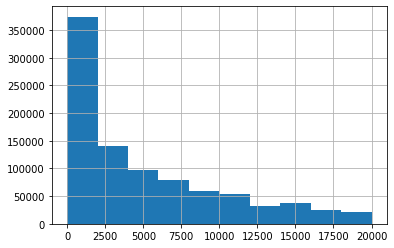

In [78]:
df_container_volume[(df_container_volume['Units Per 20ft Container'] > 0) & \
                    (df_container_volume['Units Per 20ft Container'] < 20000)]['Units Per 20ft Container'].hist();

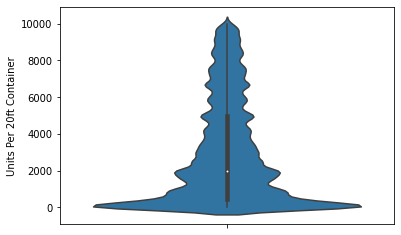

In [88]:
sns.violinplot(data=df_container_volume[(df_container_volume['Units Per 20ft Container'] > 0) & \
                    (df_container_volume['Units Per 20ft Container'] < 10000)], 
               y='Units Per 20ft Container');

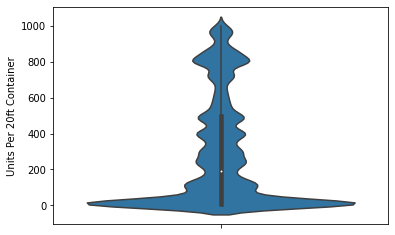

In [89]:
sns.violinplot(data=df_container_volume[(df_container_volume['Units Per 20ft Container'] > 0) & \
                    (df_container_volume['Units Per 20ft Container'] < 1000)], 
               y='Units Per 20ft Container');

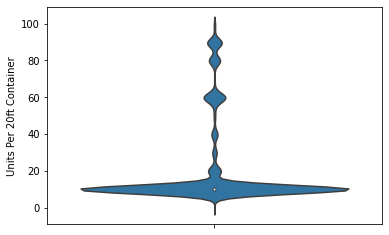

In [87]:
sns.violinplot(data=df_container_volume[(df_container_volume['Units Per 20ft Container'] > 0) & \
                    (df_container_volume['Units Per 20ft Container'] < 100)], 
               y='Units Per 20ft Container');

Seems handle `Unit Per 20ft Container == 10` items should solve the problem.  
Check some sample between 20 and 200, to make sure they're valid:

In [98]:
df_container_volume[(df_container_volume['Units Per 20ft Container'] > 20) & \
                    (df_container_volume['Units Per 20ft Container'] < 200)].sample(5).to_clipboard(index=False)

In [99]:
df_container_volume[(df_container_volume['Units Per 20ft Container'] > 200) & \
                    (df_container_volume['Units Per 20ft Container'] < 300)].sample(5).to_clipboard(index=False)

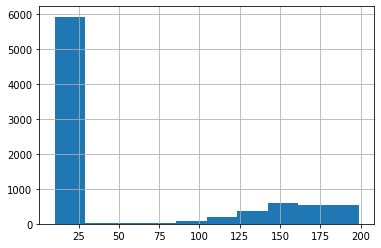

In [106]:
df_container_volume[(df_container_volume['Dept Category Desc'] == 'AUTO TIRES') & \
                   (df_container_volume['Units Per 20ft Container'] > 0) & \
                    (df_container_volume['Units Per 20ft Container'] < 200)]['Units Per 20ft Container'].hist();

In [108]:
df_container_volume[(df_container_volume['Dept Category Desc'] == 'AUTO TIRES') & \
                   (df_container_volume['Units Per 20ft Container'] > 0)]['Units Per 20ft Container'].describe()

count    38427.000000
mean       925.565618
std        997.771299
min         10.000000
25%        240.000000
50%        825.000000
75%       1485.000000
max      41675.000000
Name: Units Per 20ft Container, dtype: float64

In [109]:
df_container_volume[(df_container_volume['SBU'] == 'APPAREL') & \
                   (df_container_volume['Units Per 20ft Container'] > 0)]['Units Per 20ft Container'].describe()

count    5.444570e+05
mean     1.179592e+04
std      5.935637e+04
min      7.000000e+00
25%      9.510000e+02
50%      3.550000e+03
75%      1.043100e+04
max      1.751580e+07
Name: Units Per 20ft Container, dtype: float64

In [112]:
df_container_volume.groupby('Dept Category Desc')['Units Per 20ft Container'].quantile(.5).reset_index()

,Dept Category Desc,Units Per 20ft Container
0,4K MOVIES,0.0
1,81 HAWAII MERCHANDISE,5692.0
2,90 INCUBATION SET,0.0
3,92 INCUBATION SET L2,0.0
4,99 SUPPLIES,0.0
...,...,...
1426,WRIST WORN,3300.0
1427,WRITING,9801.0
1428,YARN AND NEEDLE CRAFT,4754.0
1429,YOGURT,12319.0


In [141]:
def replace_outliers(df, outlier_threshold, 
                     replace_quantile=0.5, 
                     replace_agg=['Dept Category Desc'],
                    replace_col='Units Per 20ft Container'):
    ''' 
    Replace outliers smaller than @outlier_threshold in @replace_col, 
    with @repalce_quantile of its @replace_agg group.
    '''
    # Generate value to replace outliers
    replace_value_col = replace_col + "_replace_value"
    if replace_value_col in df.columns:
        # remove column if exist
        df.drop(columns=[replace_value_col], inplace=True) 
    agg_quantile = df[df[replace_col] > 0].groupby(replace_agg)[replace_col].quantile(replace_quantile).reset_index()
    agg_quantile.rename(columns={replace_col: replace_value_col}, inplace=True)
    df = df.merge(agg_quantile, on=replace_agg)
    
    # Replace outliers
    replaced_col = replace_col + "_outlier_replaced"
    df[replaced_col] = np.where((df[replace_col] > 0) & (df[replace_col] < outlier_threshold), 
                               df[replace_value_col], df[replace_col])
    return df

In [215]:
df_container_volume[(df_container_volume['Units Per 20ft Container'] > 0) & \
                   (df_container_volume['Units Per 20ft Container'] < 100)].shape[0]

104382

In [204]:
df_test = replace_outliers(df_container_volume, 100)

In [205]:
df_test = replace_outliers(df_test, 100, replace_agg=['Department Desc'])

In [206]:
df_test = replace_outliers(df_test, 100, replace_agg=['SBU'])

In [207]:
df_test[(df_test['Units Per 20ft Container_outlier_replaced'] > 0) & (df_test['Units Per 20ft Container_outlier_replaced'] < 100)]

,SBU,Item Number,Department Desc,Dept Category Desc,UPC Number,Item Description,Country of Origin,Net Ship Units,Net Ships Cost,Net Ship Retail,...,Units Per 20ft Container,Estimated 40ft Containers Per Month,Units Per 40ft Container,Channel_Clean,Estimated 20ft Containers,Estimated 40ft Containers,Calculated 20ft Containers,Calculated 40ft Containers,Units Per 20ft Container_outlier_replaced,Units Per 20ft Container_replace_value
1585538,OTHERS,576644671,HEARING CENTER,HEARING AIDS,81294402562,2bhfl Rie Tubes Hifit110,CN,72.0,4608.00,5964.00,...,40.0,0.08,80.0,Domestic-Import,1.80,0.96,1.800000,0.900000,30.0,30.0
1585539,OTHERS,576644672,HEARING CENTER,HEARING AIDS,81294402563,2bhfr Rie Tube Hifit110,CN,100.0,6400.00,8089.00,...,40.0,0.10,80.0,Domestic-Import,2.52,1.20,2.500000,1.250000,30.0,30.0
1585541,OTHERS,576644674,HEARING CENTER,HEARING AIDS,81294402565,3bhfr Rie Tube Hifit110,CN,28.0,1792.00,2439.00,...,19.0,0.06,39.0,Domestic-Import,1.44,0.72,1.473684,0.717949,30.0,30.0
1585554,OTHERS,595483149,HEARING CENTER,HEARING AIDS,81294402757,Rechargeable Battery Beige,TH,248.0,17853.52,25803.04,...,10.0,1.03,20.0,Domestic-Import,24.84,12.36,24.800000,12.400000,30.0,30.0
1585555,OTHERS,595483166,HEARING CENTER,HEARING AIDS,81294402758,Rechargeable Battery Charger,TH,123.0,15742.77,25268.36,...,10.0,0.51,20.0,Domestic-Import,12.36,6.12,12.300000,6.150000,30.0,30.0
1585560,OTHERS,576644665,HEARING CENTER,HEARING AIDS,81294402695,U-32 Channel Hearing Aid Beige,CN,22.0,15758.88,36005.00,...,19.0,0.05,39.0,Domestic-Import,1.08,0.60,1.157895,0.564103,30.0,30.0
1585575,OTHERS,582113197,HEARING CENTER,HEARING AIDS,81294402825,U64 Ch Ha Brn,US,10.0,9783.14,14638.00,...,10.0,0.04,20.0,Domestic,0.96,0.48,1.000000,0.500000,30.0,30.0
1585576,OTHERS,582113198,HEARING CENTER,HEARING AIDS,81294402823,U64 Ch Ha Bge,US,83.0,69714.11,138505.00,...,20.0,0.17,40.0,Domestic,4.20,2.04,4.150000,2.075000,30.0,30.0
1585579,OTHERS,582113202,HEARING CENTER,HEARING AIDS,81294402788,U16 Ch Ha Brn,US,4.0,1045.26,4262.00,...,10.0,0.02,20.0,Domestic,0.36,0.24,0.400000,0.200000,30.0,30.0
1585581,OTHERS,594765580,HEARING CENTER,HEARING AIDS,81294402853,A32 Hearing Aid Grey,CN,8.0,4555.92,6048.00,...,10.0,0.03,20.0,Domestic-Import,0.84,0.36,0.800000,0.400000,30.0,30.0


In [208]:
df_test['Calculated 20ft Containers_NO_Outlier'] = np.where(df_test['Units Per 20ft Container_outlier_replaced'] > 0,
                                                                    df_test['Net Ship Units'] / df_test['Units Per 20ft Container_outlier_replaced'],
                                                            0)

In [209]:
check_agg(df_test, ['Channel_Clean'], 
         ['Net Ship Retail',
           'Net Ship Units',
             'Net Ships Cost',
         'Calculated 20ft Containers_NO_Outlier']).to_clipboard()

In [173]:
check_agg(df_test, ['Channel_Clean'], 
         ['Net_Ship_Retail',
           'Net_Ship_Units',
             'Net_Ships_Cost',
         'Calculated_20ft_Containers_NO_Outlier']).to_clipboard()

In [149]:
import pandas_gbq
from google.cloud import bigquery
%reload_ext google.cloud.bigquery
# Set your default project here
pandas_gbq.context.project = 'wmt-edw-sandbox'
pandas_gbq.context.dialect = 'standard'

In [210]:
# formact column type
df_test['UPC Number'] = df_test['UPC Number'].astype('int64')
# format column names before uploading
df_test.columns = [col.replace(" ", "_") for col in df_test.columns]
df_test.to_gbq('AD_HOC_RQ.BRI_Initiative_Import_Items',project_id='wmt-edw-sandbox',if_exists='replace')

1it [07:45, 465.71s/it]


In [179]:
# load item level report data
start_time = time.time()
df_item = load_csv_data_from_folder(item_folder_path, skiprows=0)
end_time = time.time()

duration_time = round(end_time - start_time, 0)
print(f"File read in {duration_time // 60} minutes and {duration_time % 60} seconds")

Loading apparel_item_national_dep1.csv
Loading apparel_item_national_dep2.csv
Loading apparel_item_national_dep3.csv
Loading apparel_item_private.csv
Loading consumable_item.csv
Loading entertainment_item.csv
Loading food_item.csv
Loading HL_item.csv
Loading Home_item.csv
Loading HW_item.csv
Loading Others_item.csv
Loading Toys_item.csv
File read in 0.0 minutes and 35.0 seconds


In [183]:
df_item_brand = df_item[['Item Number', 'Brand Indicator']].copy()

In [185]:
df_item_brand.drop_duplicates(inplace=True)

In [187]:
df_item_brand['Item Number'].value_counts(ascending=False)

595595262    1
7363439      1
595823762    1
565674900    1
595045265    1
            ..
662406598    1
591109573    1
652417817    1
591113667    1
595591168    1
Name: Item Number, Length: 3875724, dtype: int64

In [188]:
# save to bq table
df_item_brand.columns = [col.replace(" ", "_") for col in df_item_brand.columns]
df_item_brand.to_gbq('AD_HOC_RQ.BRI_Initiative_Import_Item_Brand',project_id='wmt-edw-sandbox',if_exists='replace')

1it [01:31, 91.85s/it]


In [211]:
%%bigquery df_final

create or replace table `wmt-edw-sandbox.AD_HOC_RQ.BRI_Initiative_Import_Final` as (
select SBU,
  Department_Desc,
  Dept_Category_Desc,
  b.Brand_Indicator,
  Country_of_Origin,
  Channel,
  Channel_Clean,
  sum(Net_Ship_Units) as Net_Ship_Units,
  sum(Net_Ships_Cost) as Net_Ships_Cost,
  sum(Net_Ship_Retail) as Net_Ship_Retail,
  sum(Calculated_20ft_Containers_NO_Outlier) as Estimated_20ft_Containers_NO_Outlier
from `wmt-edw-sandbox.AD_HOC_RQ.BRI_Initiative_Import_Items` a 
left join `wmt-edw-sandbox.AD_HOC_RQ.BRI_Initiative_Import_Item_Brand` b 
  on a.Item_Number = b.Item_Number
group by 1,2,3,4,5,6,7
order by 1,2,3,4,5,6,7
);

select *
from `wmt-edw-sandbox.AD_HOC_RQ.BRI_Initiative_Import_Final`

Downloading: 100%|███████████████████████████████████████████████████████████| 13863/13863 [00:02<00:00, 5582.17rows/s]


In [212]:
check_agg(df_final, ['SBU', 'Channel_Clean', 'Brand_Indicator'],
          ['Net_Ship_Units', 'Net_Ships_Cost', 'Net_Ship_Retail', 'Estimated_20ft_Containers_NO_Outlier']).to_clipboard()

In [213]:
check_agg(df_final, ['Channel_Clean', 'Brand_Indicator'],
          ['Net_Ship_Units', 'Net_Ships_Cost', 'Net_Ship_Retail', 'Estimated_20ft_Containers_NO_Outlier']).to_clipboard()

In [216]:
df_final.to_csv(container_folder_path + "//category_level_final_data.csv")

In [223]:
df_test[df_test['Units_Per_20ft_Container_outlier_replaced'] > 0].groupby('Channel_Clean')[['Units_Per_20ft_Container_outlier_replaced']].describe()

Units_Per_20ft_Container_outlier_replaced                \
                                                    count          mean   
Channel_Clean                                                             
Domestic                                         391691.0  28151.754973   
Domestic-Import                                  631949.0  21793.910113   
Import                                           138545.0  30648.715666   

                                                                            
                           std    min     25%     50%      75%         max  
Channel_Clean                                                               
Domestic         138721.235679   30.0  2699.0  7687.0  18731.0  30417561.0  
Domestic-Import  145895.057174   30.0  1700.0  3987.0  11428.0  46080000.0  
Import           165119.152098  100.0  3300.0  8750.0  19454.0  13430304.0

In [228]:
df_test[df_test['Channel_Clean'] == 'Import'].sort_values('Calculated_20ft_Containers_NO_Outlier',
                                                         ascending=False).head(20).to_clipboard()

In [225]:
df_test.columns

Index(['SBU', 'Item_Number', 'Department_Desc', 'Dept_Category_Desc',
       'UPC_Number', 'Item_Description', 'Country_of_Origin', 'Net_Ship_Units',
       'Net_Ships_Cost', 'Net_Ship_Retail', 'Channel',
       'Estimated_20ft_Containers_Per_Month', 'Units_Per_20ft_Container',
       'Estimated_40ft_Containers_Per_Month', 'Units_Per_40ft_Container',
       'Channel_Clean', 'Estimated_20ft_Containers',
       'Estimated_40ft_Containers', 'Calculated_20ft_Containers',
       'Calculated_40ft_Containers',
       'Units_Per_20ft_Container_outlier_replaced',
       'Units_Per_20ft_Container_replace_value',
       'Calculated_20ft_Containers_NO_Outlier'],
      dtype='object')

In [230]:
df_test2 = replace_outliers(df_container_volume, 500)
df_test2 = replace_outliers(df_test2, 500, replace_agg=['Department Desc'])
df_test2 = replace_outliers(df_test2, 500, replace_agg=['SBU'])

In [233]:
df_test2['Calculated 20ft Containers_NO_Outlier'] = np.where(df_test2['Units Per 20ft Container_outlier_replaced'] > 0,
                                                                    df_test2['Net Ship Units'] / df_test2['Units Per 20ft Container_outlier_replaced'],
                                                            0)

In [243]:
outlier_500 = df_test2.merge(df_item_brand, on='Item_Number', how='left')

In [246]:
outlier_500.groupby(['Brand_Indicator', 'SBU', 'Channel_Clean'])['Calculated_20ft_Containers_NO_Outlier'].sum().to_clipboard()

In [258]:
def test_outliers(outlier_threshold, df, df_item_brand):
    ''' 
    Returns a DataFrame with units per 20ft container < @outlier_threshold replaced.
    Merged with brand_indicator.
    '''
    df_test2 = replace_outliers(df, outlier_threshold)
    df_test2 = replace_outliers(df_test2, outlier_threshold, replace_agg=['Department Desc'])
    df_test2 = replace_outliers(df_test2, outlier_threshold, replace_agg=['SBU'])
    df_test2['Calculated 20ft Containers_NO_Outlier'] = np.where(df_test2['Units Per 20ft Container_outlier_replaced'] > 0,
                                                                    df_test2['Net Ship Units'] / df_test2['Units Per 20ft Container_outlier_replaced'],
                                                            0)
    
    df_test2.columns = [col.replace(" ", "_") for col in df_test2.columns]
    outlier_df = df_test2.merge(df_item_brand, on='Item_Number', how='left')
    return outlier_df

In [248]:
outlier_1000 = test_outliers(1000, df_container_volume, df_item_brand)

In [249]:
outlier_1000.groupby(['Brand_Indicator', 'SBU', 'Channel_Clean'])['Calculated_20ft_Containers_NO_Outlier'].sum().to_clipboard()

In [251]:
outlier_200 = test_outliers(200, df_container_volume, df_item_brand)

In [252]:
outlier_200.groupby(['Brand_Indicator', 'SBU', 'Channel_Clean'])['Calculated_20ft_Containers_NO_Outlier'].sum().to_clipboard()

In [253]:
outlier_1500 = test_outliers(1500, df_container_volume, df_item_brand)
outlier_1500.groupby(['Brand_Indicator', 'SBU', 'Channel_Clean'])['Calculated_20ft_Containers_NO_Outlier'].sum().to_clipboard()

In [254]:
outlier_300 = test_outliers(300, df_container_volume, df_item_brand)
outlier_300.groupby(['Brand_Indicator', 'SBU', 'Channel_Clean'])['Calculated_20ft_Containers_NO_Outlier'].sum().to_clipboard()

In [255]:
outlier_100 = test_outliers(100, df_container_volume, df_item_brand)
outlier_100.groupby(['Brand_Indicator', 'SBU', 'Channel_Clean'])['Calculated_20ft_Containers_NO_Outlier'].sum().to_clipboard()

In [257]:
outlier_2000 = test_outliers(2000, df_container_volume, df_item_brand)
outlier_2000.groupby(['Brand_Indicator', 'SBU', 'Channel_Clean'])['Calculated_20ft_Containers_NO_Outlier'].sum().to_clipboard()

### Process only ship metrics

In [24]:
folder_path = r'C:\Users\y0q00wv\Documents\Roger Qin\Data Analytics\BRI Import Analysis\Spine Reports - Ship Metrics'
df = load_data_from_folder(folder_path, skiprows=10)

Loading apparel_ship.xlsx
Loading consumable_ship.xlsx
Loading entertain_ship.xlsx
Loading food_ship.xlsx
Loading HL_ship.xlsx
Loading Home_ship.xlsx
Loading HW_ship.xlsx
Loading Other_ship.xlsx
Loading toys_ship.xlsx


In [26]:
clean_channel(df, 'Channel', 'Country of Origin', 'United States')

In [29]:
df.groupby('Channel_Clean').sum().to_clipboard()